In [38]:
import xarray
import geopandas as gpd
import numpy as np
import pandas as pd
import s3fs
import geoglows
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

In [39]:
bucket_uri = 's3://geoglows-v2-retrospective/retrospective.zarr'
region_name = 'us-west-2'
s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(region_name=region_name))
s3store = s3fs.S3Map(root=bucket_uri, s3=s3, check=False)

ds = xarray.open_zarr(s3store)

In [40]:
results = []

linkno_files = {
    160221792: "/Users/rachel1/Downloads/rachel nile/kenya_1GD03.csv",
    160266239: "/Users/rachel1/Downloads/rwanda_4326.csv",
    160194980: '/Users/rachel1/Downloads/rachel nile/fix/70012.csv',
    130613583: '/Users/rachel1/Downloads/rachel nile/fix/196501_2.csv',
    160205470: '/Users/rachel1/Downloads/rachel nile/fix/221001.csv',
    160266239: '/Users/rachel1/Downloads/rachel nile/fix/259501.csv',
    160233531: '/Users/rachel1/Downloads/rachel nile/fix/270001.csv',
    160200814: '/Users/rachel1/Downloads/rachel nile/fix/294701.csv',
    160212524: '/Users/rachel1/Downloads/rachel nile/fix/298001.csv',
    160217207: '/Users/rachel1/Downloads/rachel nile/fix/SW5.csv',
    160157611: '/Users/rachel1/Downloads/rachel nile/fix/SW27.csv',
    160157611: '/Users/rachel1/Downloads/rachel nile/fix/SW28.csv',
    160157611: '/Users/rachel1/Downloads/rachel nile/fix/SW29.csv',
    160157611: '/Users/rachel1/Downloads/rachel nile/fix/SW30.csv',
    160161112: '/Users/rachel1/Downloads/rachel nile/fix/282001.csv'
    # 160212492: "/Users/rachel1/Downloads/rachel nile/grdc_1270900.csv",
    # 160168155: "/Users/rachel1/Downloads/rachel nile/grdc_1269200.csv",
    # 160213625: "/Users/rachel1/Downloads/rachel nile/grdc_1769050.csv",
    # 160184420: "/Users/rachel1/Downloads/rachel nile/grdc_1769100.csv",
    # 160191425: "/Users/rachel1/Downloads/rachel nile/grdc_1769200.csv",
    # 160128354: "/Users/rachel1/Downloads/rachel nile/grdc_1769150.csv",
    # 160504154: "/Users/rachel1/Downloads/rachel nile/grdc_1563680.csv",
    # 160528679: "/Users/rachel1/Downloads/rachel nile/grdc_1563700.csv",
    # 160622096: "/Users/rachel1/Downloads/rachel nile/grdc_1563900.csv",
    # 160590528: "/Users/rachel1/Downloads/rachel nile/grdc_1563600.csv",
    # 160536792: "/Users/rachel1/Downloads/rachel nile/grdc_1563450.csv",
    # 160596343: "/Users/rachel1/Downloads/rachel nile/grdc_1563500.csv",
    # 160608077: "/Users/rachel1/Downloads/rachel nile/grdc_1563550.csv",
    # 160553167: "/Users/rachel1/Downloads/rachel nile/grdc_1563050.csv",

}

In [41]:
def find_start_row(file_path, column_index=1):
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            # Split the line by comma and check the second column
            columns = line.strip().split(',')
            if len(columns) > column_index:
                try:
                    float(columns[column_index])  # Check if it's a number
                    return i  # Return the row number
                except ValueError:
                    continue
    return 0

In [42]:
stdStart = 1991
stdEnd = 2020

In [47]:
def HydroSOS(flowdata):
    flowdata.columns = ['date', 'flow']
    # flowdata['date'] = pd.to_datetime(flowdata['date'], format="%d/%m/%Y")
    flowdata['date'] = pd.to_datetime(flowdata['date'])  # Ensure the 'date' column is in datetime format
    # flowdata['date'] = flowdata['date'].dt.strftime('%d/%m/%Y')

    # check dates are sequential

    diff = pd.date_range(start=flowdata['date'].min(), end=flowdata['date'].max()).difference(flowdata['date'])
    if len(diff) > 0:
        flowdata.set_index('date', inplace=True)
        for md in diff:
            flowdata.loc[md, 'flow'] = pd.NA
        flowdata.reset_index(inplace=True)
    # month and year column
    flowdata['month'] = flowdata['date'].dt.month
    flowdata['year'] = flowdata['date'].dt.year

    # check whether or not there is enough data?
    print(f"There are {flowdata['year'].max() - flowdata['year'].min()} years of data in this file.")
    print(f"There are {sum(flowdata['flow'].isnull())} missing data points, which is {np.round(sum(flowdata['flow'].isnull())/len(flowdata) * 100,4)}% of the total data")
    # print("starting step 1")
    """ STEP 1: CALCULATE MEAN MONTHLY FLOWS """

    # calculate percentage completeness for each year/month
    groupBy = (flowdata.groupby(['month', 'year']).count()['flow'] / flowdata.groupby(['month', 'year']).count()[
        'date']) * 100
    groupBy = pd.DataFrame(groupBy)
    groupBy.rename(columns={0: 'monthly%'}, inplace=True)
    # calculate mean flows for each year/month
    groupBy['mean_flow'] = flowdata.groupby(['month', 'year'])['flow'].mean()
    # set the mean flow to NAN if there is less than 50 % data
    # groupBy.loc[groupBy['monthly%'] < 50,'mean_flow'] = pd.NA
    groupBy.reset_index(inplace=True)
    # print("finished step 1")
    """ STEP 2: CALCULATE MEAN MONTHLY FLOWS AS A PERCENTAGE OF AVERAGE """

    # calculate long term average
    LTA = groupBy[(groupBy['year'] >= stdStart) & (groupBy['year'] <= stdEnd)].groupby(['month'])[
        'mean_flow'].mean()
    if LTA.empty:
        # print("Skipping")
        return
    # print("NOT SKIPPED")

    # divide each month by this long term average
    for i in range(1, 13):
        groupBy.loc[groupBy['month'] == i, 'percentile_flow'] = groupBy['mean_flow'][groupBy['month'] == i] / LTA[
            i] * 100
    # print("FINISHED STEP 2")
    """ STEP 3: CALCULATE RANK PERCENTILES """
    # na values automatically set as rank na
    for i in range(1, 13):
        groupBy.loc[groupBy['month'] == i, 'weibell_rank'] = groupBy.loc[
                                                                 groupBy['month'] == i, 'percentile_flow'].rank(
            na_option='keep') / (groupBy.loc[groupBy['month'] == i, 'percentile_flow'].count() + 1)
    # print("FINISHED STEP 3")
    """ STEP 4: ASSIGN STATUS CATEGORIES """

    def flow_status(weibell_rank):
        status = pd.NA
        if weibell_rank <= 0.13:
            status = 1
        elif weibell_rank <= 0.28:
            status = 2
        elif weibell_rank <= 0.71999:
            status = 3
        elif weibell_rank <= 0.86999:
            status = 4
        elif weibell_rank <= 1:
            status = 5
        return status

    for i in groupBy.index:
        groupBy.loc[i, 'flowcat'] = flow_status(groupBy.loc[i, 'weibell_rank'])
    # print("FINISHED STEP 4")
    """ STEP 5: WRITE DATA """
    groupBy['date'] = pd.to_datetime(groupBy[['year', 'month']].assign(DAY=1))
    groupBy['date'] = groupBy['date'].dt.strftime('%Y-%m-%d')
    groupBy['flowcat'] = groupBy['flowcat'].astype('Int64')
    return (groupBy.sort_values(['year', 'month']).filter(['date', 'flowcat']))

160221792
NOT SKIPPED
160221792_geoglows  1  2   3  4  5
160221792_gauge                   
1                   5  3   4  0  0
2                   3  6   2  1  0
3                   8  8  32  8  3
4                   0  0   3  7  2
5                   0  1   1  6  4


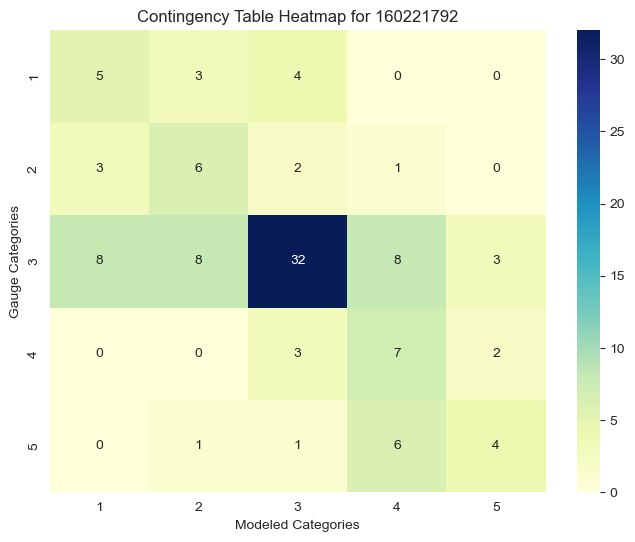

Chi-Square Statistic: 60.782996683950074
p-value: 3.860682517452034e-07
Degrees of Freedom: 16
Expected Frequencies:
[[ 1.79439252  2.01869159  4.71028037  2.46728972  1.00934579]
 [ 1.79439252  2.01869159  4.71028037  2.46728972  1.00934579]
 [ 8.82242991  9.92523364 23.1588785  12.13084112  4.96261682]
 [ 1.79439252  2.01869159  4.71028037  2.46728972  1.00934579]
 [ 1.79439252  2.01869159  4.71028037  2.46728972  1.00934579]]
Cohen's Kappa: 0.31
160266239
NOT SKIPPED
160266239_geoglows  1  2  3
160266239_gauge            
3                   6  3  3


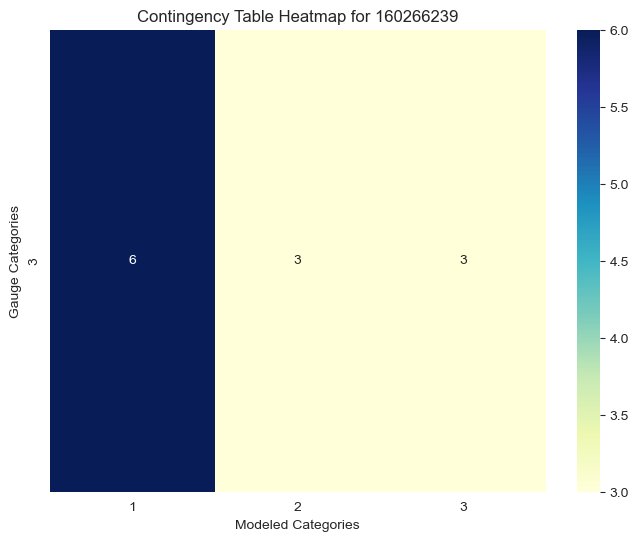

Chi-Square Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[6. 3. 3.]]
Cohen's Kappa: 0.00
160194980
NOT SKIPPED
160194980_geoglows  1  2  3
160194980_gauge            
3                   4  1  4


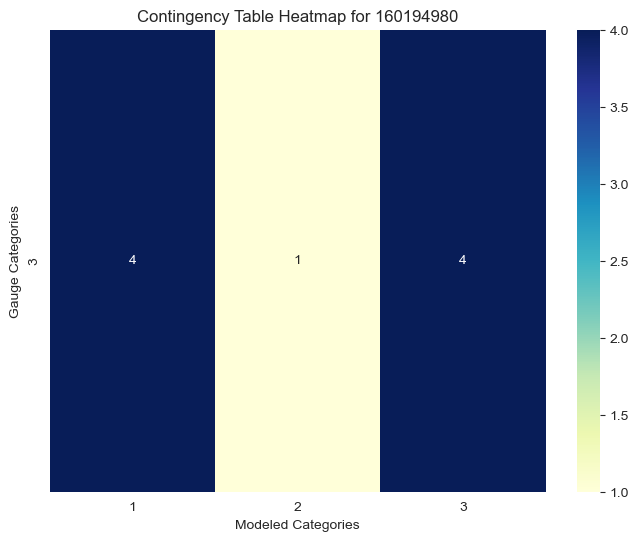

Chi-Square Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[4. 1. 4.]]
Cohen's Kappa: 0.00
130613583
NOT SKIPPED
130613583_geoglows   1   2   3   4   5
130613583_gauge                       
1                    0   6  14   3   1
2                    4   5  24   7   7
3                   12  14  51  23  14
4                    4  10  13  11   9
5                    4   1  13   4   2


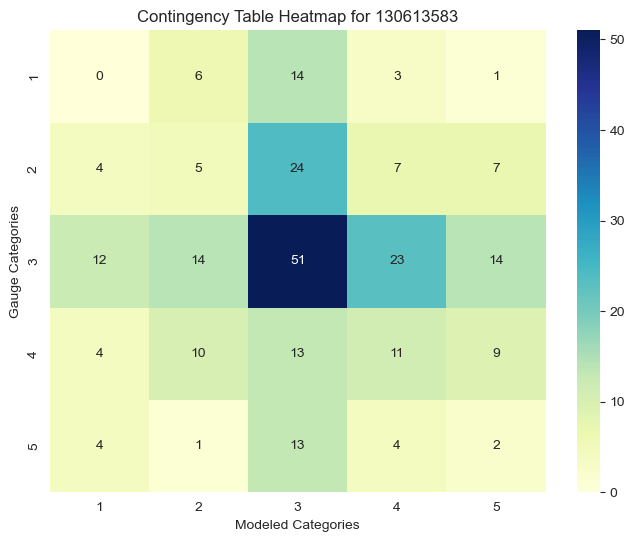

Chi-Square Statistic: 19.88541644433363
p-value: 0.225425850717897
Degrees of Freedom: 16
Expected Frequencies:
[[ 2.25        3.375      10.78125     4.5         3.09375   ]
 [ 4.40625     6.609375   21.11328125  8.8125      6.05859375]
 [10.6875     16.03125    51.2109375  21.375      14.6953125 ]
 [ 4.40625     6.609375   21.11328125  8.8125      6.05859375]
 [ 2.25        3.375      10.78125     4.5         3.09375   ]]
Cohen's Kappa: -0.02
160205470
NOT SKIPPED
160205470_geoglows  1   2   3   4   5
160205470_gauge                      
1                   1   4  12   2   5
2                   2   4  12   9   4
3                   6  10  48  12  12
4                   2   1  20   8   0
5                   0   3   9   9   3


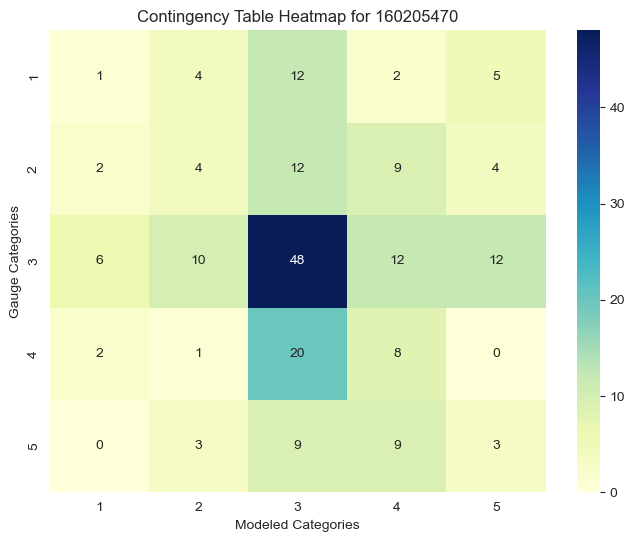

Chi-Square Statistic: 21.633828685287884
p-value: 0.1554130912413711
Degrees of Freedom: 16
Expected Frequencies:
[[ 1.33333333  2.66666667 12.24242424  4.84848485  2.90909091]
 [ 1.72222222  3.44444444 15.81313131  6.26262626  3.75757576]
 [ 4.88888889  9.77777778 44.88888889 17.77777778 10.66666667]
 [ 1.72222222  3.44444444 15.81313131  6.26262626  3.75757576]
 [ 1.33333333  2.66666667 12.24242424  4.84848485  2.90909091]]
Cohen's Kappa: 0.04
160233531
NOT SKIPPED
160233531_geoglows   1   2    3   4   5
160233531_gauge                        
1                   13  12   23   9   3
2                    7  14   39  13  11
3                   24  34  110  43  25
4                    8  14   34  15  13
5                    2   6   21  16  15


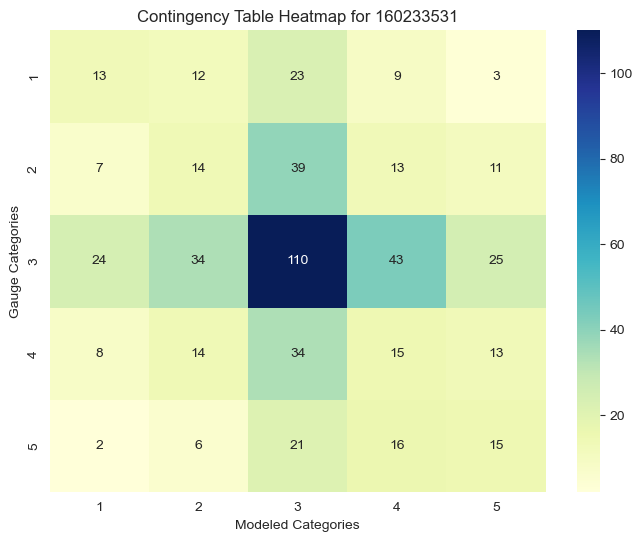

Chi-Square Statistic: 29.492855860246905
p-value: 0.020816938096055518
Degrees of Freedom: 16
Expected Frequencies:
[[  6.18320611   9.16030534  25.99236641  10.99236641   7.67175573]
 [  8.65648855  12.82442748  36.38931298  15.38931298  10.74045802]
 [ 24.32061069  36.03053435 102.23664122  43.23664122  30.17557252]
 [  8.65648855  12.82442748  36.38931298  15.38931298  10.74045802]
 [  6.18320611   9.16030534  25.99236641  10.99236641   7.67175573]]
Cohen's Kappa: 0.06
160200814
NOT SKIPPED
160200814_geoglows  1  2  3
160200814_gauge            
3                   4  2  6


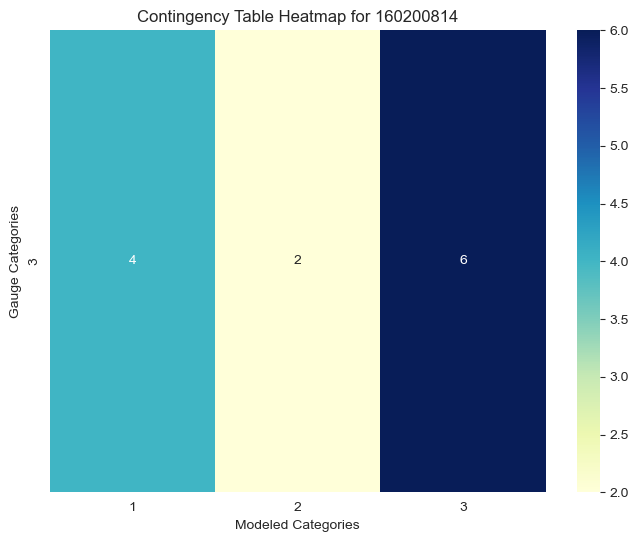

Chi-Square Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[4. 2. 6.]]
Cohen's Kappa: 0.00
160212524
NOT SKIPPED
160212524_geoglows  1  2  3
160212524_gauge            
3                   5  3  4


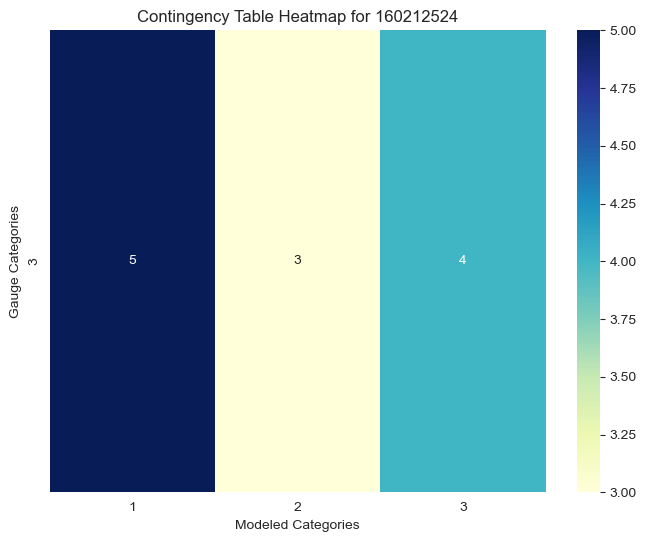

Chi-Square Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[5. 3. 4.]]
Cohen's Kappa: 0.00
160217207
NOT SKIPPED
160217207_geoglows  1  2  3
160217207_gauge            
3                   4  4  5


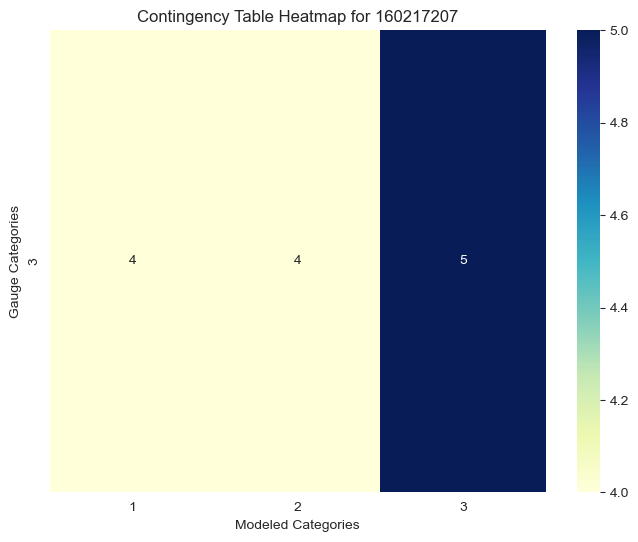

Chi-Square Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[4. 4. 5.]]
Cohen's Kappa: 0.00
160157611
160161112
NOT SKIPPED
160161112_geoglows  1  2  3
160161112_gauge            
3                   3  6  4


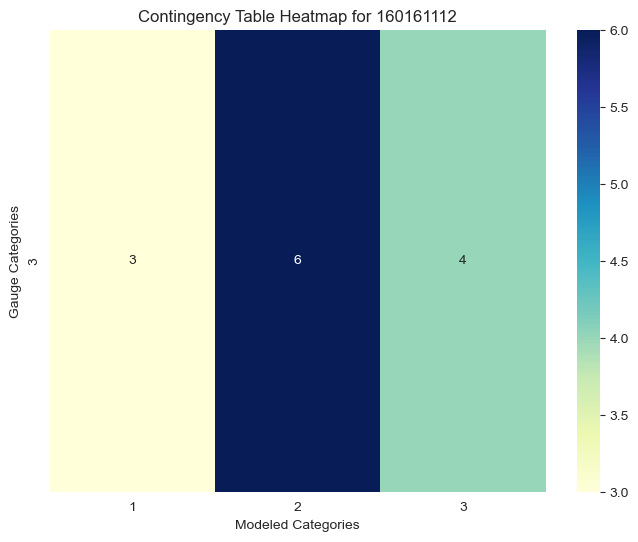

Chi-Square Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[3. 6. 4.]]
Cohen's Kappa: 0.00


In [46]:
results = pd.DataFrame()

for linkno, file_path in linkno_files.items():
    print(linkno)
    df = ds['Qout'].sel(rivid=linkno).to_dataframe()
    df = df.reset_index().set_index('time').pivot(columns='rivid', values='Qout')
    df = df[(df.index > '1950-12-31')]
    df = df[df[linkno] >= 0]
    df.reset_index(inplace=True)
    start_row = find_start_row(file_path)
    gauge = pd.read_csv(
        file_path,
        skiprows=start_row,
        header=None,  # Do not use the first row as column names
        parse_dates=[0]  # Parse the first column as datetime
    )
    gauge.columns = ['Datetime', 'Streamflow (m3/s)']
    gauge = gauge[gauge['Streamflow (m3/s)'] >= 0]
    # If no specific format is known and you need to handle two-digit years:
    gauge['Datetime'] = pd.to_datetime(
        gauge['Datetime'], errors='coerce', yearfirst=True
    )

    # Explicitly correct any misinterpreted years
    # Assuming dates later than the current year are incorrect:
    current_year = pd.Timestamp.now().year
    gauge['Datetime'] = gauge['Datetime'].apply(
        lambda x: x.replace(year=x.year - 100) if x.year > current_year else x
    )
   # gauge['Datetime'] = pd.to_datetime(gauge['Datetime'], errors='coerce')
    gauge.set_index('Datetime', inplace=True)
    gauge.reset_index(inplace=True)

    unique_years = gauge['Datetime'].dt.year.nunique()
    if unique_years < 2:
        print(f"Skipping linkno {linkno} due to insufficient data ({unique_years} years)")
        continue

    geoglows_sos = HydroSOS(df)

    # print("FINISHED GEOGLOWS")
    gauge_sos = HydroSOS(gauge)
    if gauge_sos is not None:
        # Rename the value columns while preserving the 'time' column
        gauge_sos.rename(columns={gauge_sos.columns[1]: f"{linkno}_gauge"}, inplace=True)
        geoglows_sos.rename(columns={geoglows_sos.columns[1]: f"{linkno}_geoglows"}, inplace=True)

        # Combine the DataFrames along columns, aligning by 'time'
        combined_df = pd.merge(
            gauge_sos, geoglows_sos, on=gauge_sos.columns[0], how="inner"
        )


        if results.empty:
            # Initialize the results DataFrame with the first pair of data
            results = pd.merge(
                gauge_sos, geoglows_sos, on=gauge_sos.columns[0], how="outer"
            )
        else:
            # Merge new results into the existing DataFrame
            results = pd.merge(
                results, gauge_sos, on=gauge_sos.columns[0], how="outer"
            )
            results = pd.merge(
                results, geoglows_sos, on=geoglows_sos.columns[0], how="outer"
            )
        filtered_df = results.dropna(subset=[f"{linkno}_gauge", f"{linkno}_geoglows"])
        # Create the contingency table
        contingency_table = pd.crosstab(filtered_df[f"{linkno}_gauge"], filtered_df[f"{linkno}_geoglows"])
        print(contingency_table)
        plt.figure(figsize=(8, 6))
        sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d", cbar=True)
        plt.title(f"Contingency Table Heatmap for {linkno}")
        plt.xlabel("Modeled Categories")
        plt.ylabel("Gauge Categories")
        plt.show()
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Results
        print(f"Chi-Square Statistic: {chi2}")
        print(f"p-value: {p}")
        print(f"Degrees of Freedom: {dof}")
        print("Expected Frequencies:")
        print(expected)
        # Compute Cohen's Kappa
        kappa = cohen_kappa_score(filtered_df[f"{linkno}_gauge"], filtered_df[f"{linkno}_geoglows"])
        print(f"Cohen's Kappa: {kappa:.2f}")

In [28]:
linkno = 160221792

In [32]:
# Drop rows with NaN values in either 'Gauge' or 'Modeled' columns
filtered_df = results.dropna(subset=[f"{linkno}_gauge", f"{linkno}_geoglows"])

# Create the contingency table
contingency_table = pd.crosstab(filtered_df[f"{linkno}_gauge"], filtered_df[f"{linkno}_geoglows"])

In [34]:
contingency_table

160221792_geoglows,1,2,3,4,5
160221792_gauge,,,,,
1,5,3,4,0,0
2,3,6,2,1,0
3,8,8,32,8,3
4,0,0,3,7,2
5,0,1,1,6,4


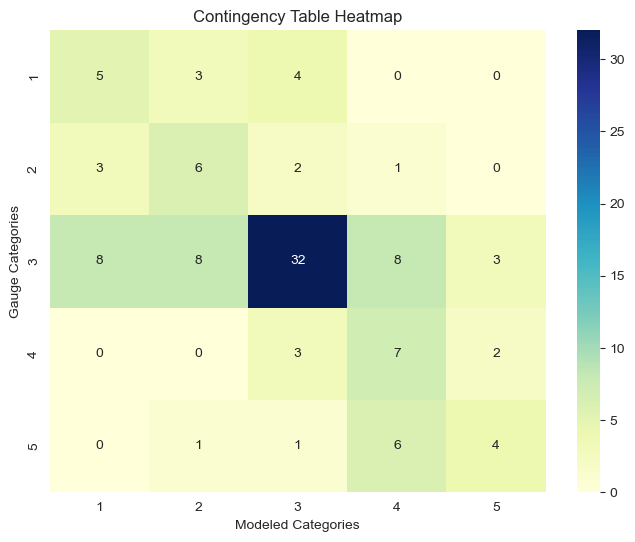

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d", cbar=True)
plt.title("Contingency Table Heatmap")
plt.xlabel("Modeled Categories")
plt.ylabel("Gauge Categories")
plt.show()

In [36]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Results
print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Chi-Square Statistic: 60.782996683950074
p-value: 3.860682517452034e-07
Degrees of Freedom: 16
Expected Frequencies:
[[ 1.79439252  2.01869159  4.71028037  2.46728972  1.00934579]
 [ 1.79439252  2.01869159  4.71028037  2.46728972  1.00934579]
 [ 8.82242991  9.92523364 23.1588785  12.13084112  4.96261682]
 [ 1.79439252  2.01869159  4.71028037  2.46728972  1.00934579]
 [ 1.79439252  2.01869159  4.71028037  2.46728972  1.00934579]]


In [ ]:
filtered_df

In [37]:
# Compute Cohen's Kappa
kappa = cohen_kappa_score(filtered_df[f"{linkno}_gauge"], filtered_df[f"{linkno}_geoglows"])

print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.31


In [ ]:
kappa